                Stitching usando método SURF com Flann 

In [13]:
import timeit
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [34]:
class Matcher:
    def __init__(self):
        self.surf = cv2.xfeatures2d.SURF_create() #Cria o objeto de SURF
        index_params = dict(algorithm=0, trees=5) 
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)
        """ Matcher treina em uma coleção de descritores e usa metodos de busca
        de pontos proximos para encontrar melhores combinações"""
        
    def match(self, first_image, second_image):
        image_set_1 = self.get_SURF_features(first_image)
        image_set_2 = self.get_SURF_features(second_image)
        matches = self.flann.knnMatch(image_set_2["des"], image_set_1["des"], k=2)
        """ KnnMatche, busca as correspondências de pontos chaves 
            em duas imagens.
        """
        good_points = []
        
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                good_points.append((m.trainIdx, m.queryIdx))
                
        if len(good_points) > 4:
            points_current = image_set_2["kp"]
            points_previous = image_set_1["kp"]
            
            matched_points_current = np.float32(
                [points_current[i].pt for (__, i) in good_points]
            )
            
            matched_points_prev = np.float32(
                [points_previous[i].pt for (i, __) in good_points]
            )
            
            mx_homography, _ = cv2.findHomography(
                matched_points_current, matched_points_prev, cv2.RANSAC, 4
            )
            return mx_homography
        return None
    
    def get_SURF_features(self, image):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        key_points , descriptor = self.surf.detectAndCompute(gray_image, None)
        return {"kp": key_points, "des": descriptor}
            

In [49]:
class Stitcher:
    
    def __init__(
        self,
        crop_x_min=None,
        crop_x_max=None,
        crop_y_min=None,
        crop_y_max=None,
    ):
        
        self.matcher_obj = Matcher()
        self.homography_cache = {}
        self.overlay_cache = {}
        
        self.crop_x_min = crop_x_min
        self.crop_x_max = crop_x_max
        self.crop_y_min = crop_y_min
        self.crop_y_max = crop_y_max
    
    def stitch(self, images=[]):
        
        self.images = images
        self.count = len(images)
        self.prepare_lists()
        self.left_shift()
        self.right_shift()
        
        if self.crop_x_min and self.crop_x_max and self.crop_y_min and self.crop_y_max:
            return self.result[
                self.crop_y_min : self.crop_y_max, self.crop_x_min : self.crop_x_max
            ]
        else:
            return self.result
    
    def prepare_lists(self):
        
        self.left_list = []
        self.right_list = []
        
        self.center_index = int(self.count / 2)
        
        self.result = self.images[self.center_index]
        
        for i in range(self.count):
            if i <= self.center_index:
                self.left_list.append(self.images[i])
            else:
                self.right_list.append(self.images[i])
                
    def get_homography(self, first_image, first_image_key, second_image, second_image_key, direction):
        
        cache_key = "_".join([first_image_key, second_image_key, direction])
        homography = self.homography_cache.get(cache_key, None)
        
        if homography is None:
            
            homography = self.matcher_obj.match(first_image, second_image)
            self.homography_cache[cache_key] = homography
            
        return homography
    
    def left_shift(self):
        
        center_image = self.left_list[0]
        
        for index, image in enumerate(self.left_list[1:]):
            
            mx_homography = self.get_homography(center_image, str(index), image, str(index + 1), "left")
            inverse_homography = np.linalg.inv(mx_homography)
            
            ds = np.dot(inverse_homography, np.array([center_image.shape[1], center_image.shape[0], 1]))
            ds = ds/ ds[-1]
            
            f1 = np.dot(inverse_homography, np.array([0,0,1]))
            f1 = f1/ f1[-1]
            
            inverse_homography[0][-1] += abs(f1[0])
            inverse_homography[0][-1] += abs(f1[1])
            
            ds = np.dot(inverse_homography, np.array([center_image.shape[1], center_image.shape[0], 1]))
            offsety = abs(int(f1[1]))
            offsetx = abs(int(f1[0]))
            
            dimension_size = (round(int(ds[0])) + offsetx + 100, round(int(ds[1])) + offsety + 100)
            
            image_temp = cv2.warpPerspective(
                center_image, 
                inverse_homography, 
                dimension_size, 
                borderMode=cv2.BORDER_TRANSPARENT
            )
            
            image_temp[
                offsety : image.shape[0] + offsety, offsetx: image.shape[1] + offsetx
            ] = image
            
            center_image = image_temp
       
        self.result = image_temp

    def right_shift(self):
        
        for index, image_right in enumerate(self.right_list):
            image_left = self.result
            
            mx_homography = self.get_homography(image_left, str(index), image_right, str(index + 1), "right")

            result = cv2.warpPerspective(
                image_right,
                mx_homography,
                (image_left.shape[1] + image_right.shape[1], image_left.shape[0] + image_left.shape[1]),
                borderMode=cv2.BORDER_TRANSPARENT,
            )
            
            mask = np.zeros((result.shape[0], result.shape[1], 3), dtype="uint8")
            mask[0: image_left.shape[0], 0 : image_left.shape[1]] = image_left
            self.result = self.blend_images(mask, result, str(index))
            
    def blend_images(self, background, foreground, i):
        
        only_right = self.overlay_cache.get(i, None)
        if only_right is None:
            only_right = np.nonzero(
                (np.sum(foreground, 2) != 0) * (np.sum(background, 2) == 0)
            )
            self.overlay_cache[i] = only_right
        
        background[only_right] = foreground[only_right]
        return background

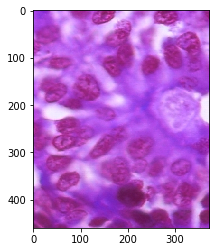

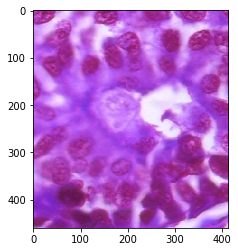

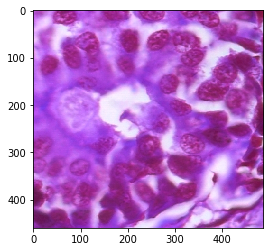

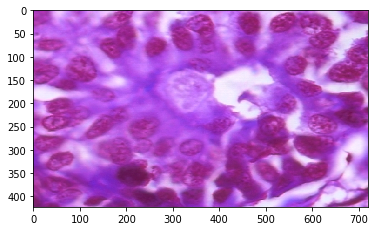

In [50]:
 if __name__ == "__main__":
    FRAME_WIDTH = 492
    FRAME_HEIGHT = 460

    shanghai_files = [
        "img400x_1.png",
        "img400x_2.png",
        "img400x_3.png",
    ]
    
    for f in shanghai_files:
        img = cv2.imread(f)
        plt.imshow(img)
        plt.show()
    
    shanghai = [
        cv2.resize(cv2.imread(f), (FRAME_WIDTH, FRAME_HEIGHT)) for f in shanghai_files
    ]

    crop_x_min = 30
    crop_x_max = 750
    crop_y_min = 37
    crop_y_max = 460

    s = Stitcher(
        crop_x_min=crop_x_min,
        crop_x_max=crop_x_max,
        crop_y_min=crop_y_min,
        crop_y_max=crop_y_max,
    )

    panorama = s.stitch(shanghai)
    
    plt.imshow(panorama)
    plt.show()

In [37]:

Detecção e descrição de ponto-chave, mais rápida que o SIFT.
Criada em 2006 por Bay, H., Tuytelaars, T. e Van Gool, L. 

Log com Box Filter, aproximação que facilita o calculo da convolução com 
filtro de caixa através de imagens integrais e depende da determinante da 
matriz Hessiana para escala e localização.

Para atribuição de orientação, o SURF usa respostas wavelet na direção 
horizontal e vertial para umma vizinhnça 6s ( Juntamente com pesos gaussianos)

Para descrição do recurso o SURf usa respostas Wavelet em ambas direções ( com integrais)
com uma vizinhança do tamanho 20sX20s

SURF usa sinal laplaciano para ponto de interesse subjacente

SURF 3x mais rápido que SIFT

kp = kaypoints
O 
SURF é um descritor 

Homografia é uma transformação projetiva que mapeia pontos de um ponto para
outro plano, matriz de transformação.

Descritores invariantes locais (SIFT)


SyntaxError: invalid syntax (<ipython-input-37-7d25b47a090a>, line 2)